
#### 1.1 How many goals were attempted by head
#### 1.2 How many matches had attendees more than 12000
#### 2.1 Shots list where goal was scored outside 16m box sorted by descending order
#### 2.2 Rank teams based on average attendance at home games 

In [15]:
from MongoStruct import *  
from ERDGraph import *

### Load all preprocessed data, dataframes and collections and show the Execution Time

In [16]:
@measure_execution_time
def MongoExecTime():
    return get_all_data()

print('----Loading Mongo----')
result, execution_time = MongoExecTime()  # Get both the result and execution time

# Unpack the 9 values from the result
client, shots_collection, matches_collection, players_collection, teams_collection, df_shots, df_matches, df_players, df_teams = result

----Loading Mongo----
shots Collection dropped
matches Collection dropped
players Collection dropped
teams Collection dropped
# shots documents: 245180
# matches documents: 14148
# players documents: 20414
# teams documents: 675
Execution time: 24.9974 seconds


In [17]:
print(df_shots.columns)
# print(df_shots.head(5))
print(df_matches.columns)
# print(df_matches.head(5))
print(df_players.columns)
# print(df_players.head(-5))
print(df_teams.columns)
# print(df_teams.head(5))

Index(['Player', 'Outcome', 'Distance', 'Body Part', 'match_id'], dtype='object')
Index(['Date', 'league', 'Round', 'Day', 'Attendance', 'home_id', 'away_id',
       'score_away', 'score_home'],
      dtype='object')
Index(['id', 'Pos', 'Matches', 'club_id', 'MP', 'year', 'name'], dtype='object')
Index(['id', 'name', 'league', 'W', 'D', 'L', 'MP', 'GF', 'GA', 'GD', 'Pts'], dtype='object')


#### 1.1 How many goals were attempted by head

In [18]:
# Define your query
query = {"Outcome": "Goal", "Body Part": "Head"}

# Create compound index beforehand if needed
def create_compound_index_1_1():
    # Create index once (if not already created)
    shots_collection.create_index([("Outcome", 1), ("Body Part", 1)], name='compound_index')

# Function to execute query with or without index
@measure_execution_time
def MongoQ1_1(index=False):
    # Create index only once outside of the query function
    if index:
        create_compound_index_1_1()
        print("Explain output --With-- index:")
    else:
        print("Explain output --Without-- index:")
    
    # Execute the query
    result = shots_collection.find(query, {"Outcome": 1, "Body Part": 1})  # Using projection to limit fields

    # Explain query execution plan
    result_index = result.explain()
    pprint.pprint(result_index["executionStats"])
    print('Query 1.1')
    
    # Return result to see output if needed
    return result

# Execute the function and measure execution time with and without index
result, execution_time = MongoQ1_1(index=False)
result_index, execution_time_index = MongoQ1_1(index=True)

# Compare execution times
print(f'--Execution is: {execution_time / execution_time_index} Times Faster with Index--')


Explain output --Without-- index:
{'allPlansExecution': [],
 'executionStages': {'advanced': 3963,
                     'executionTimeMillisEstimate': 157,
                     'inputStage': {'advanced': 3963,
                                    'direction': 'forward',
                                    'docsExamined': 245180,
                                    'executionTimeMillisEstimate': 154,
                                    'filter': {'$and': [{'Body Part': {'$eq': 'Head'}},
                                                        {'Outcome': {'$eq': 'Goal'}}]},
                                    'isEOF': 1,
                                    'nReturned': 3963,
                                    'needTime': 241217,
                                    'needYield': 0,
                                    'restoreState': 8,
                                    'saveState': 8,
                                    'stage': 'COLLSCAN',
                                    'works': 24

#### 1.2 How many matches had attendees more than 12000

In [19]:
# Define the query
query = {"Attendance": {"$gt": 12000}}

# Create index once before running queries
def create_compound_index_1_2():
    # Create index on Attendance field
    matches_collection.create_index([("Attendance", 1)], name='attendance_index')

# Function to execute query with or without index
@measure_execution_time
def MongoQ1_2(index=False):
    # Create index only once outside of the query function
    if index:
        create_compound_index_1_2()
        print("Explain output --With-- index:")
    else:
        print("Explain output --Without-- index:")
    
    # Execute the query
    result = matches_collection.find(query)  # You can add a projection if needed
    
    # Get query execution stats using correct explain() method
    result_index = result.explain() 
    # Correct usage of explain
    
    # Print the execution statistics
    pprint.pprint(result_index["executionStats"])
    
    # Return result (if you need to use or display it)
    return result

# Execute the function and measure execution time with and without index
result, execution_time = MongoQ1_2(index=False)
result_index, execution_time_index = MongoQ1_2(index=True)

# Compare execution times
print(f'--Execution is: {execution_time / execution_time_index} Times Faster with Index--')


Explain output --Without-- index:
{'allPlansExecution': [],
 'executionStages': {'advanced': 9166,
                     'direction': 'forward',
                     'docsExamined': 14148,
                     'executionTimeMillisEstimate': 0,
                     'filter': {'Attendance': {'$gt': 12000}},
                     'isCached': False,
                     'isEOF': 1,
                     'nReturned': 9166,
                     'needTime': 4982,
                     'needYield': 0,
                     'restoreState': 0,
                     'saveState': 0,
                     'stage': 'COLLSCAN',
                     'works': 14149},
 'executionSuccess': True,
 'executionTimeMillis': 7,
 'nReturned': 9166,
 'totalDocsExamined': 14148,
 'totalKeysExamined': 0}
Execution time: 0.0090 seconds
Explain output --With-- index:
{'allPlansExecution': [],
 'executionStages': {'advanced': 9166,
                     'alreadyHasObj': 0,
                     'docsExamined': 9166,
         

#### 2.1 Total Goals Scoared and Inside VS Outside 16m box

In [20]:
# Function to execute query with aggregation pipeline and player lookup
@measure_execution_time
def MongoQ2_1(index=False):
    # Define the aggregation pipeline with $lookup to join player data
    pipeline = [
        {
            '$match': {
                'Outcome': 'Goal'  # Filter for documents where Outcome is 'Goal'
            }
        },
        {
            '$group': {
                '_id': '$Player',  # Group by Player
                'gt_16': {
                    '$sum': {
                        '$cond': [{'$gt': ['$Distance', 16]}, 1, 0]  # Count distances > 16
                    }
                },
                'total_goals': {'$sum': 1}  # Count the total goals for each player
            }
        },
        {
            '$addFields': {
                'lt_16': {'$subtract': ['$total_goals', '$gt_16']}  # Compute distances <= 16
            }
        },
        {
            '$lookup': {
                'from': 'players',        # Join with 'players' collection
                'localField': '_id',      # Use 'Player' field in the current collection
                'foreignField': 'id',     # Match it with 'id' field in 'players'
                'as': 'player_info'       # Output array field
            }
        },
        {
            '$unwind': {
                'path': '$player_info',
                'preserveNullAndEmptyArrays': False  # Ignore unmatched players
            }
        },
        {
            '$group': {  # Regroup after $lookup to ensure one document per player
                '_id': '$_id',
                'Name': {'$first': '$player_info.name'},  # Take the first matched name
                'total_goals': {'$first': '$total_goals'},
                'gt_16': {'$first': '$gt_16'},
                'lt_16': {'$first': '$lt_16'}
            }
        },
        {
            '$project': {
                '_id': 0,  # Exclude the _id field
                'Name': 1,
                'total_goals': 1,
                'gt_16': 1,
                'lt_16': 1
            }
        },
        {
            '$sort': {'total_goals': -1}  # Sort by total_goals in descending order
        }
    ]

    # If index is enabled, create relevant indexes for optimization (Player, Distance)
    if index:
        shots_collection.create_index([("Player", 1), ("Distance", 1)], name="player_distance_index")
        print("Explain output --With-- index:")

    # Run aggregation pipeline on shots_collection
    result = list(shots_collection.aggregate(pipeline))

    
    return result

# Execute the function and measure execution time with or without index
result, execution_time = MongoQ2_1(index=False)
result_index, execution_time_index = MongoQ2_1(index=True)
# Dataframe for easy manipulation and visualization
df = pd.DataFrame(result)
# Return the final merged result as a pandas DataFrame
print("\nFinal Merged Results:")
df = df[['Name', 'total_goals', 'gt_16', 'lt_16']]  # Select relevant columns
print(df.head(10))  # Show top 10 results


# Compare execution times with and without the index
print(f'--Execution is: {execution_time / execution_time_index} Times Faster with Index--')


Execution time: 34.0496 seconds
Explain output --With-- index:
Execution time: 34.8412 seconds

Final Merged Results:
                 Name  total_goals  gt_16  lt_16
0       Kylian-Mbappe          147     27    120
1  Robert-Lewandowski          146     15    131
2          Harry-Kane          120     21     99
3        Lionel-Messi          106     37     69
4       Mohamed-Salah          104     14     90
5       Karim-Benzema          104     16     88
6       Ciro-Immobile          104     10     94
7      Erling-Haaland          102      7     95
8   Wissam-Ben-Yedder           92      3     89
9    Lautaro-Martinez           89     15     74
--Execution is: 0.9772777217298038 Times Faster with Index--


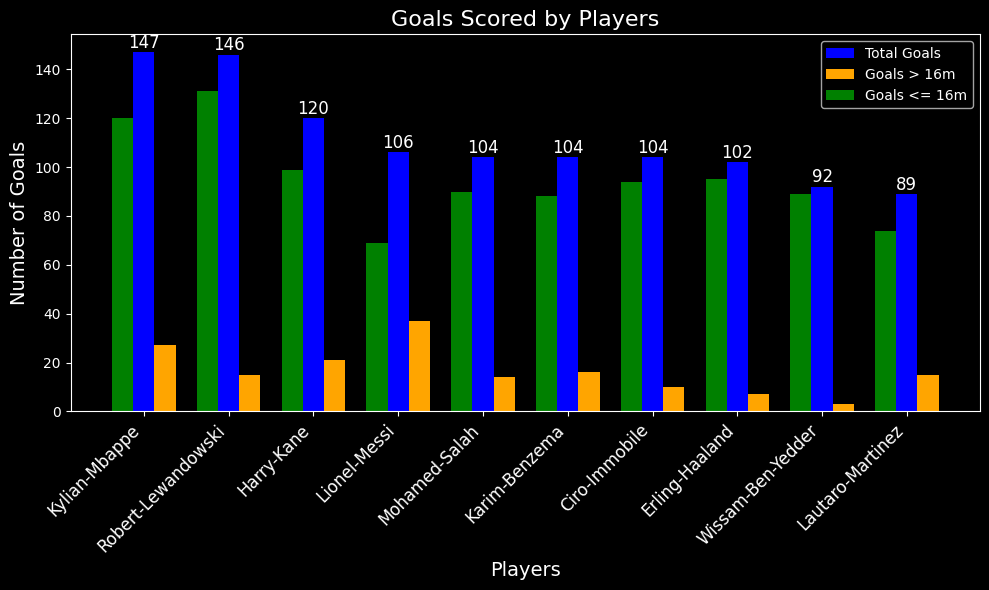

In [21]:
plot_goals_bar_chart(df.head(10))

#### 2.2 Rank teams based on average attendance at home games

In [22]:
# Function to execute query with aggregation pipeline and team lookup
@measure_execution_time
def MongoQ2_2(index=False):
    # Define aggregation pipeline with additional stages
    pipeline_1 = [
        {
            '$group': {
                '_id': '$home_id',
                'average_attendance': {'$avg': '$Attendance'},
                'matches_count': {'$sum': 1}
            }
        },
        {
            '$lookup': {
                'from': 'teams', 
                'localField': '_id', 
                'foreignField': 'id', 
                'as': 'team_info'
            }
        },
        {
            '$unwind': '$team_info'
        },
        {
            '$project': {
                '_id': 0,
                'home_id': '$_id',
                'average_attendance': 1,
                'matches_count': 1,
                'team_name': '$team_info.name'
            }
        },
        {
            '$sort': {'average_attendance': -1}
        }
    ]

    # If index is enabled, create relevant indexes for optimization (home_id, Attendance)
    if index:
        matches_collection.create_index([("home_id", 1), ("Attendance", 1)], name="home_attendance_index")
        print("Explain output --With-- index:")

    # Run aggregation pipeline on matches_collection
    result = list(matches_collection.aggregate(pipeline_1))


    return result

# Execute the function and measure execution time with or without index
result, execution_time = MongoQ2_2(index=False)
result_index, execution_time_index = MongoQ2_2(index=True)

# Dataframe for easy manipulation and visualization
df = pd.DataFrame(list(result))
# Return the final merged result as a pandas DataFrame
print("\nFinal Merged Results:")
df = df[['team_name', 'average_attendance', 'matches_count']]  # Select relevant columns
print(df.head(10))  # Show top 10 results

# Compare execution times with and without the index
print(f'--Execution is: {execution_time / execution_time_index} Times Faster with Index--')


Execution time: 0.2734 seconds
Explain output --With-- index:
Execution time: 0.3267 seconds

Final Merged Results:
           team_name  average_attendance  matches_count
0  Manchester United        56407.227273            176
1           Dortmund        56036.021583            139
2            Benfica        54471.142857             14
3       Hamburger SV        52331.000000              3
4          Barcelona        51691.458599            157
5      Bayern Munich        50702.652482            141
6        Real Madrid        47265.540373            161
7    West Ham United        46952.068966            145
8            Arsenal        46577.050000            160
9     Internazionale        46508.773585            159
--Execution is: 0.8368509958298825 Times Faster with Index--


### 4C CREATE TABLES statements

In [23]:
for i in Mongo_table_statements():
    print(i)

MongoDB Collection: shots Schema
    Player: string
    Outcome: string
    Distance: double
    Body Part: string
    match_id: string
MongoDB Collection: matches Schema
    Date: string
    league: int
    Round: int
    Day: string
    Attendance: int
    home_id: string
    away_id: string
    score_away: int
    score_home: int
MongoDB Collection: all_players Schema
    id: string
    Pos: string
    Matches: string
    club_id: string
    MP: double
    year: string
    name: string
MongoDB Collection: teams Schema
    id: string
    name: string
    league: int
    W: double
    D: double
    L: double
    MP: double
    GF: double
    GA: double
    GD: double
    Pts: double


### 4A Entity Relationship Diagram

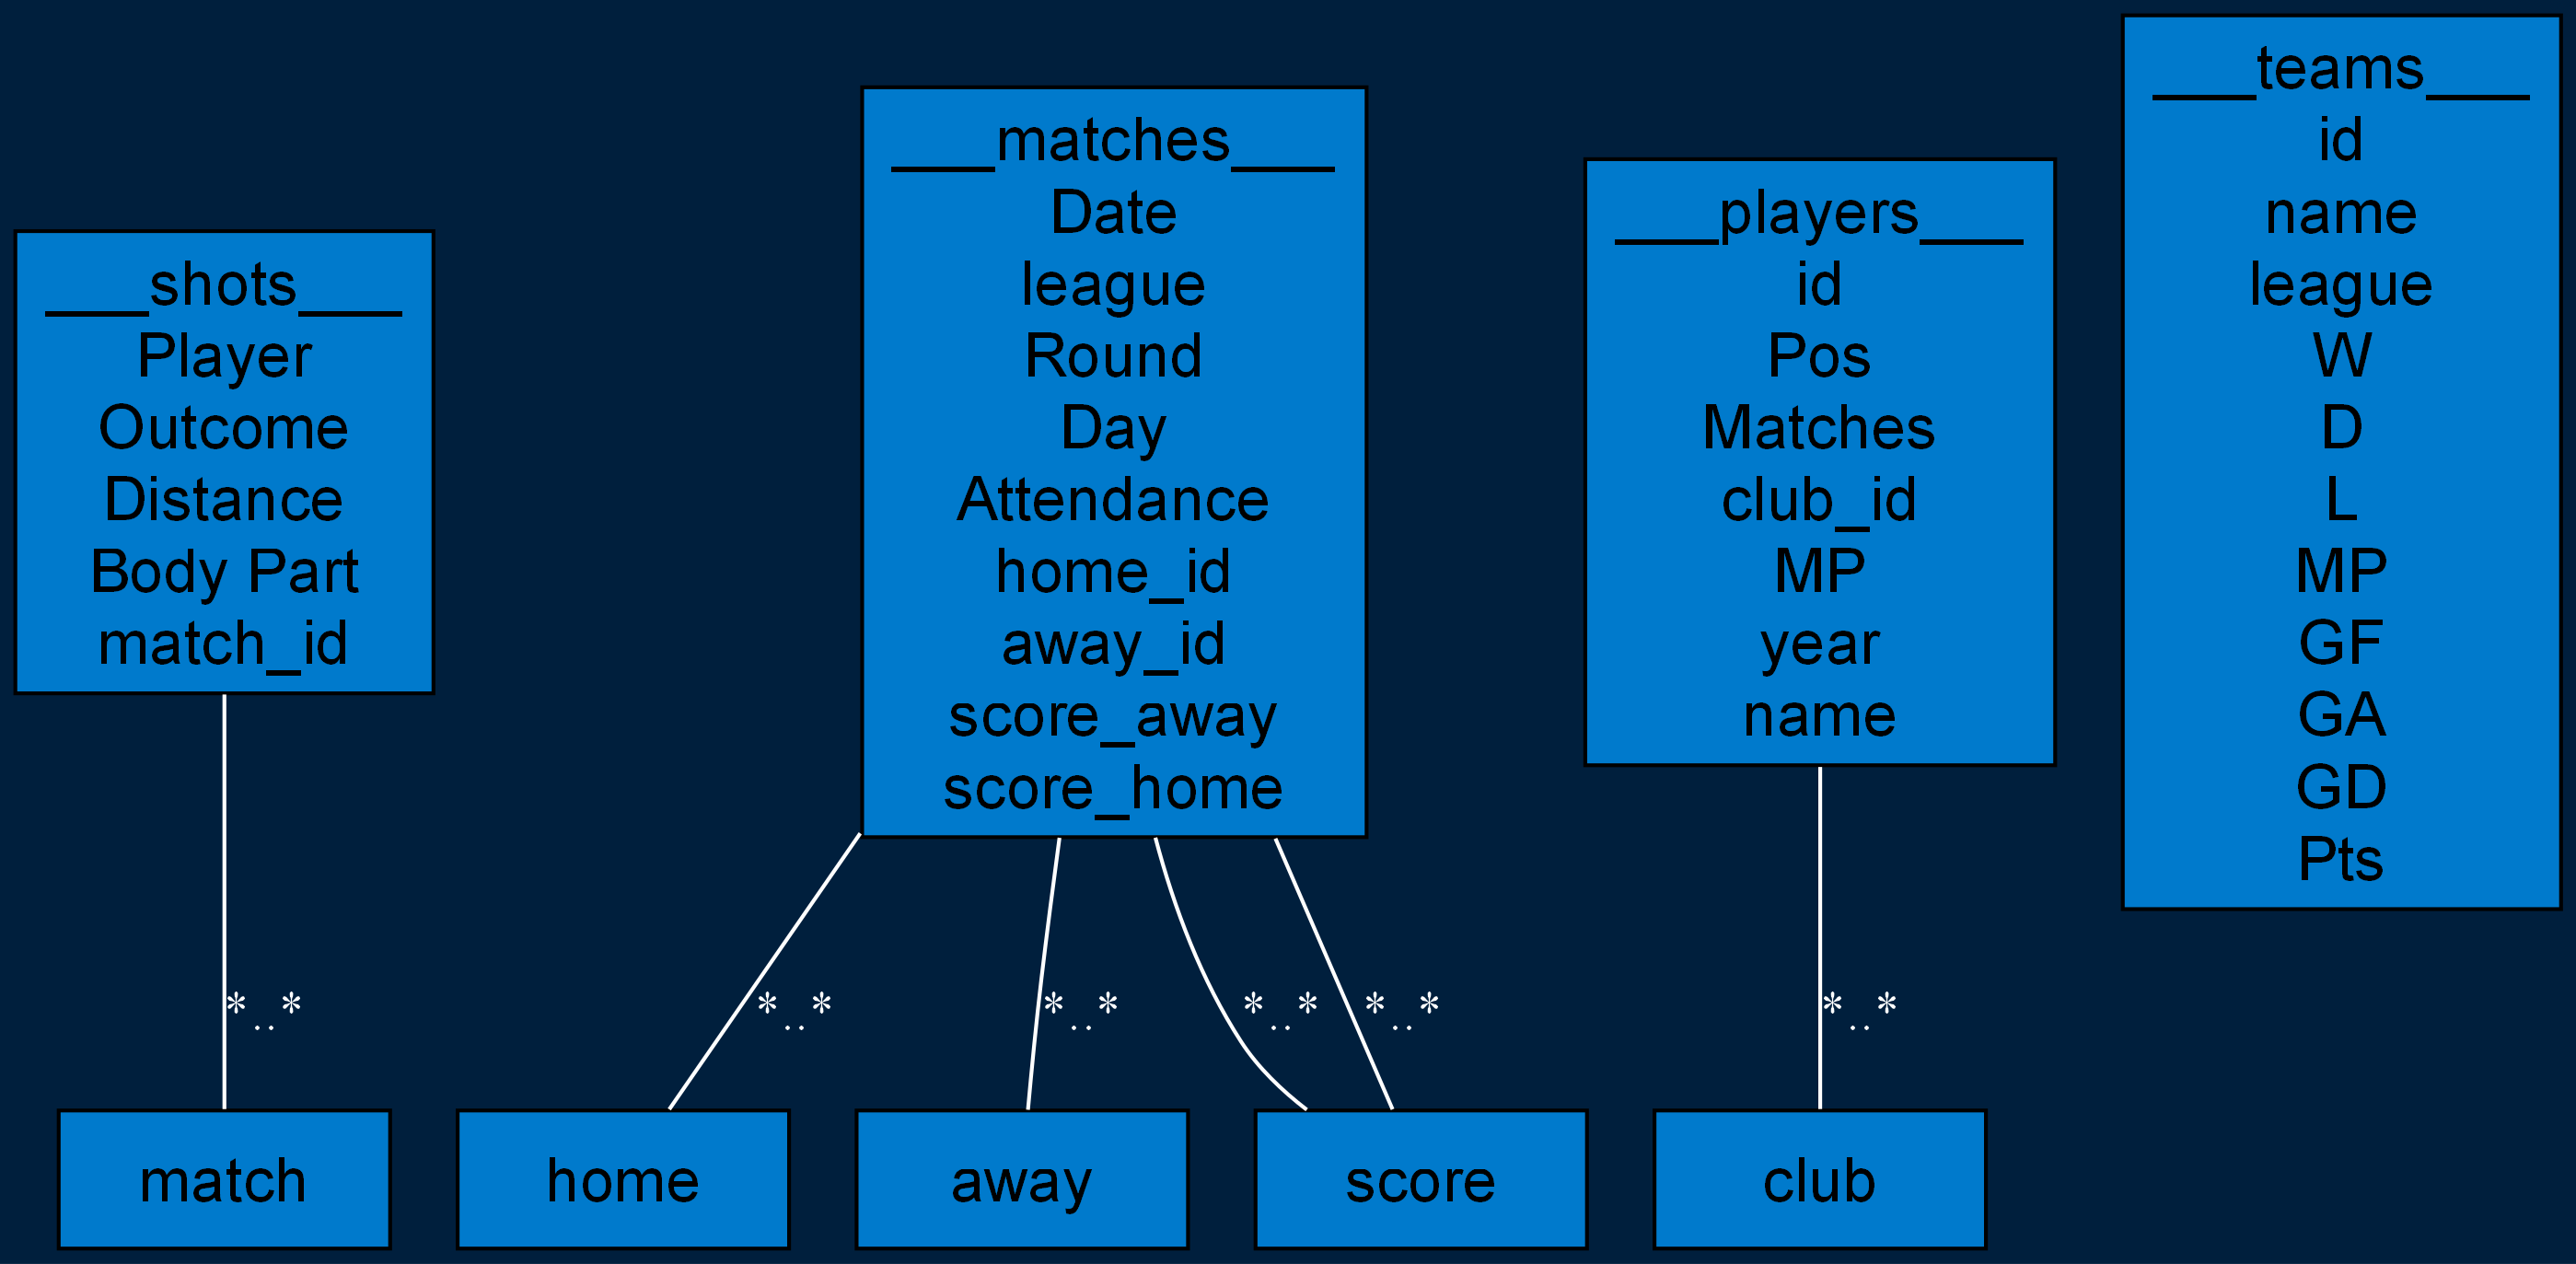

In [24]:
# Example usage
collections_info = {
    "shots": df_shots,
    "matches": df_matches,
    "players": df_players,
    "teams": df_teams
}

# Generate the ERD with increased DPI for PNG
erd_dot = generate_mongo_erd(collections_info)
erd_dot.render('mongodb_erd_with_high_resolution', format='png', view=False)  # DPI set in graph attributes

# To display in Jupyter
from IPython.display import Image
Image(filename='mongodb_erd_with_high_resolution.png')